[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\vikto\AppData\Local\Temp\ipykernel_12820\1050731257.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.018776622558345422' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  aligned_returns.at[aligned_returns.index[i], 'Target Fund'] = new_value


NaN values in SP500:
0
NaN values in VUSTX:
0
NaN values in SP500 pct change:
1
NaN values in VUSTX pct change:
1


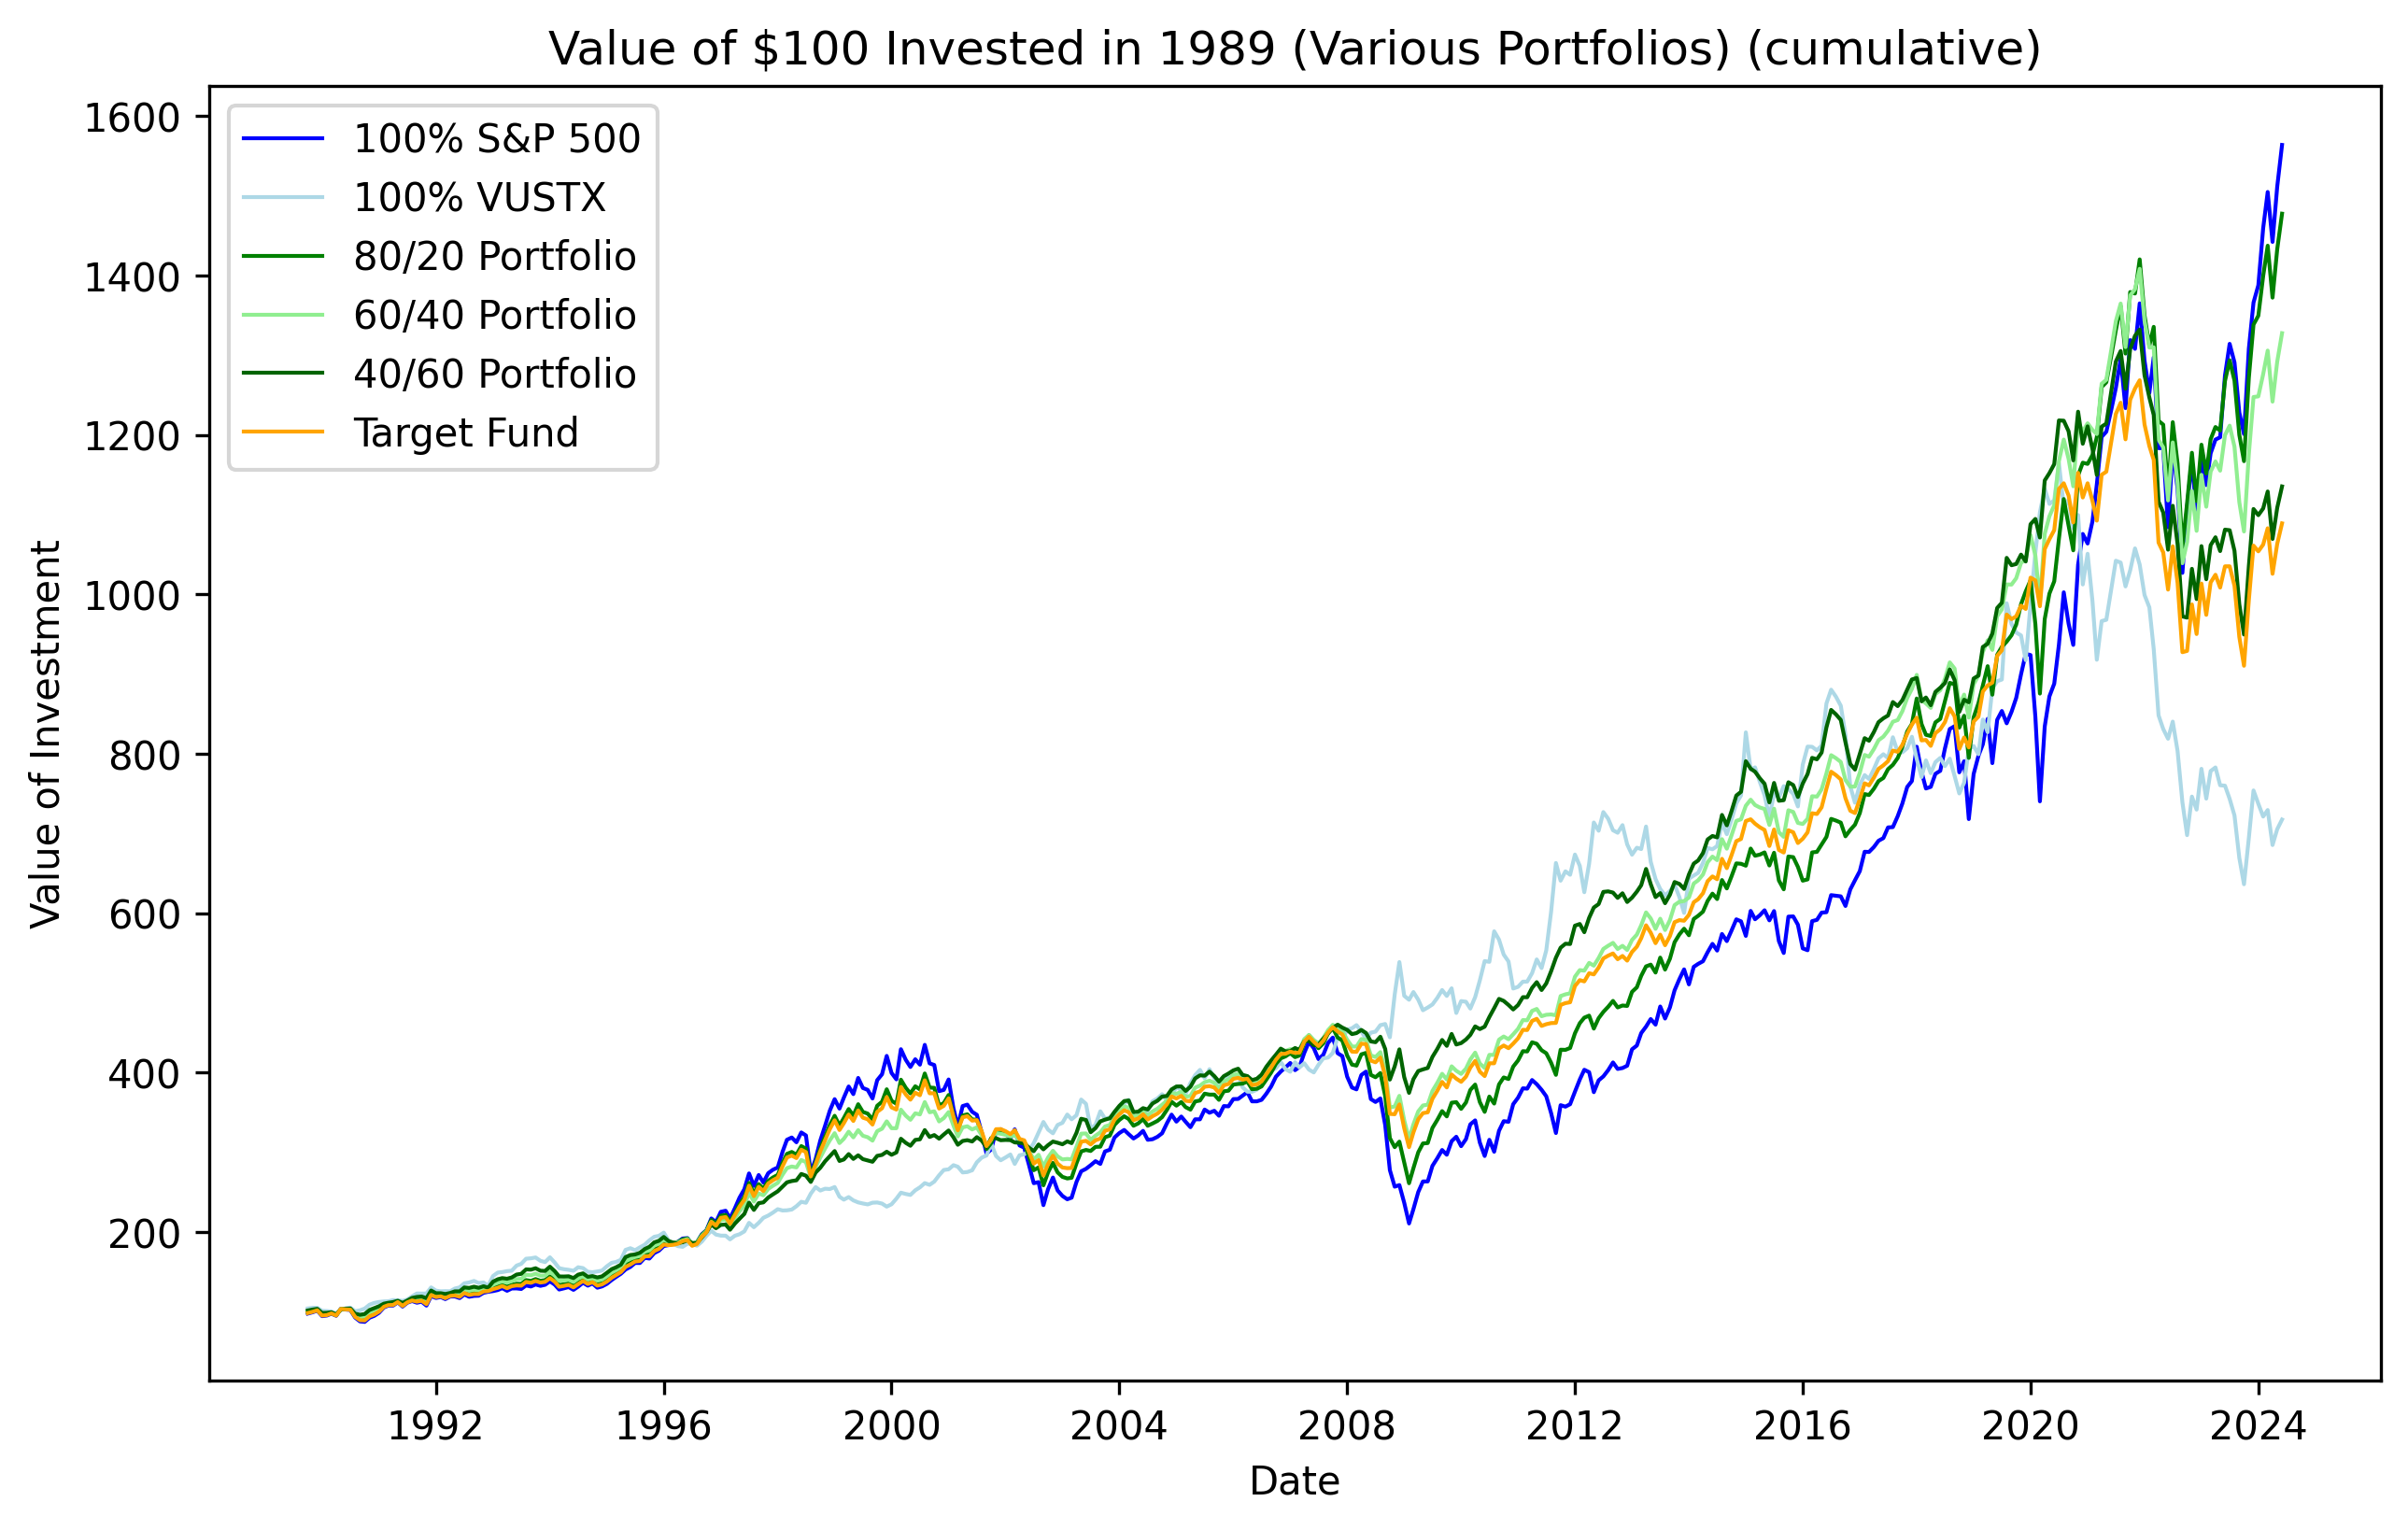

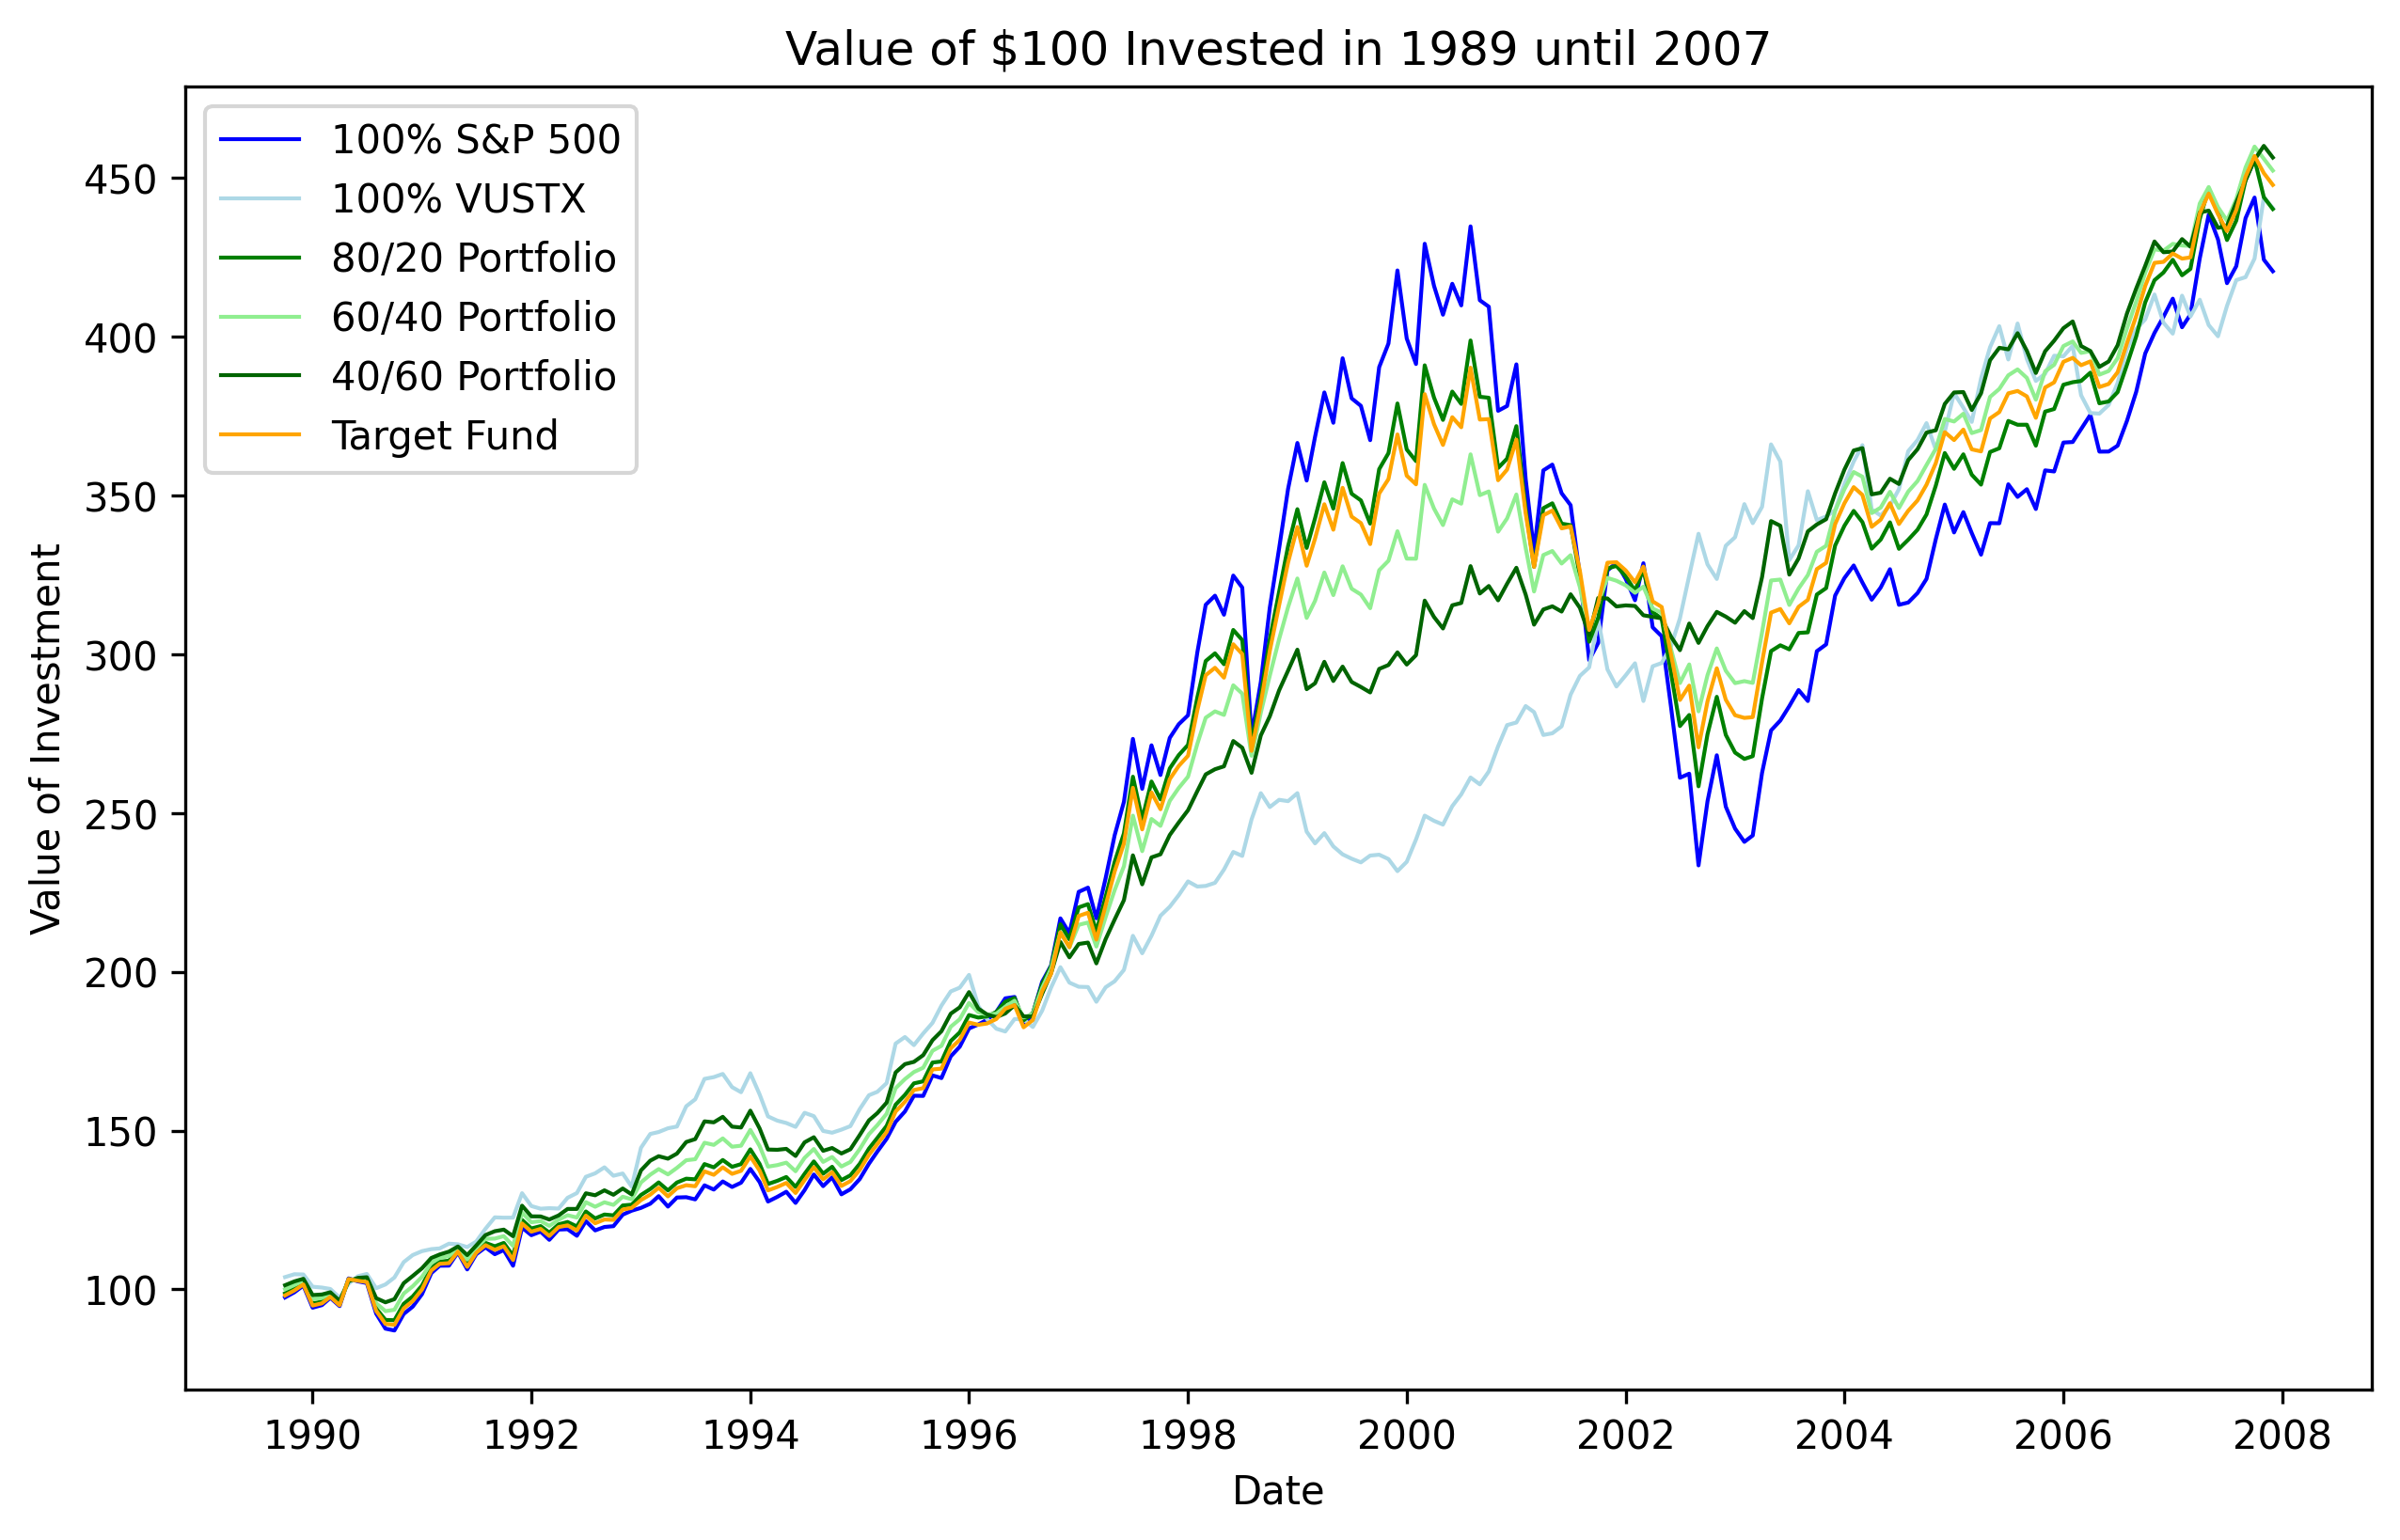

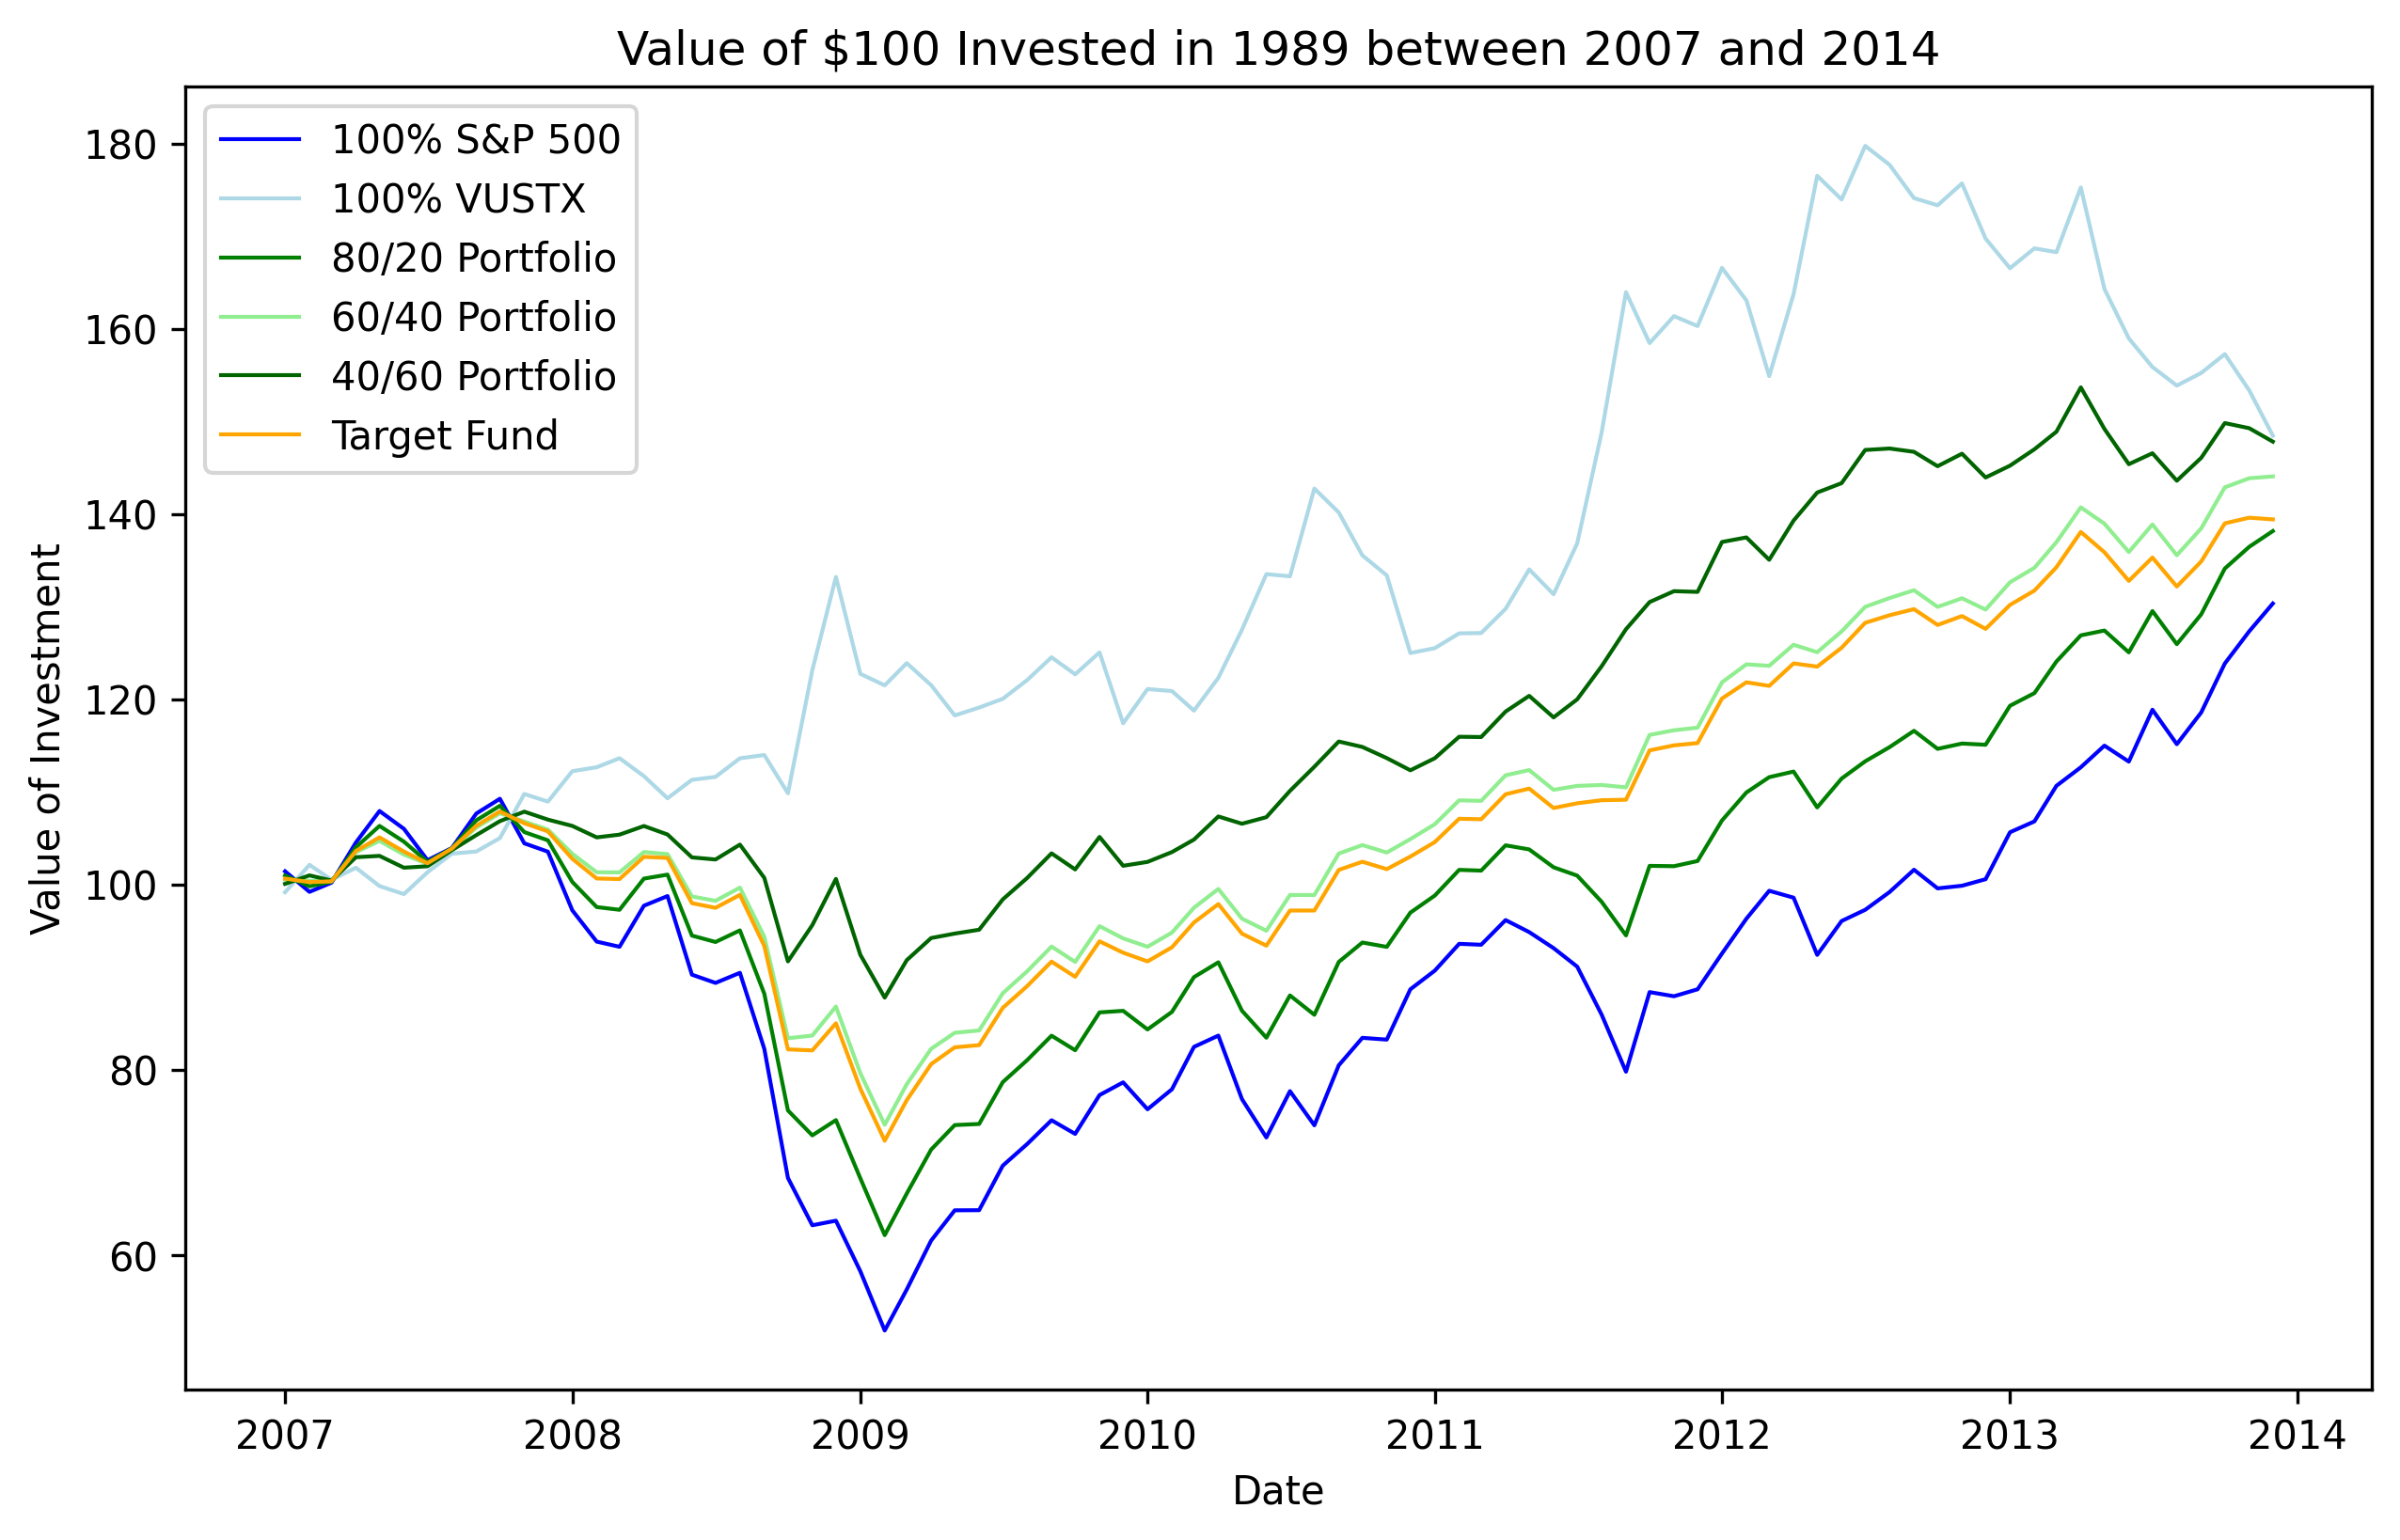

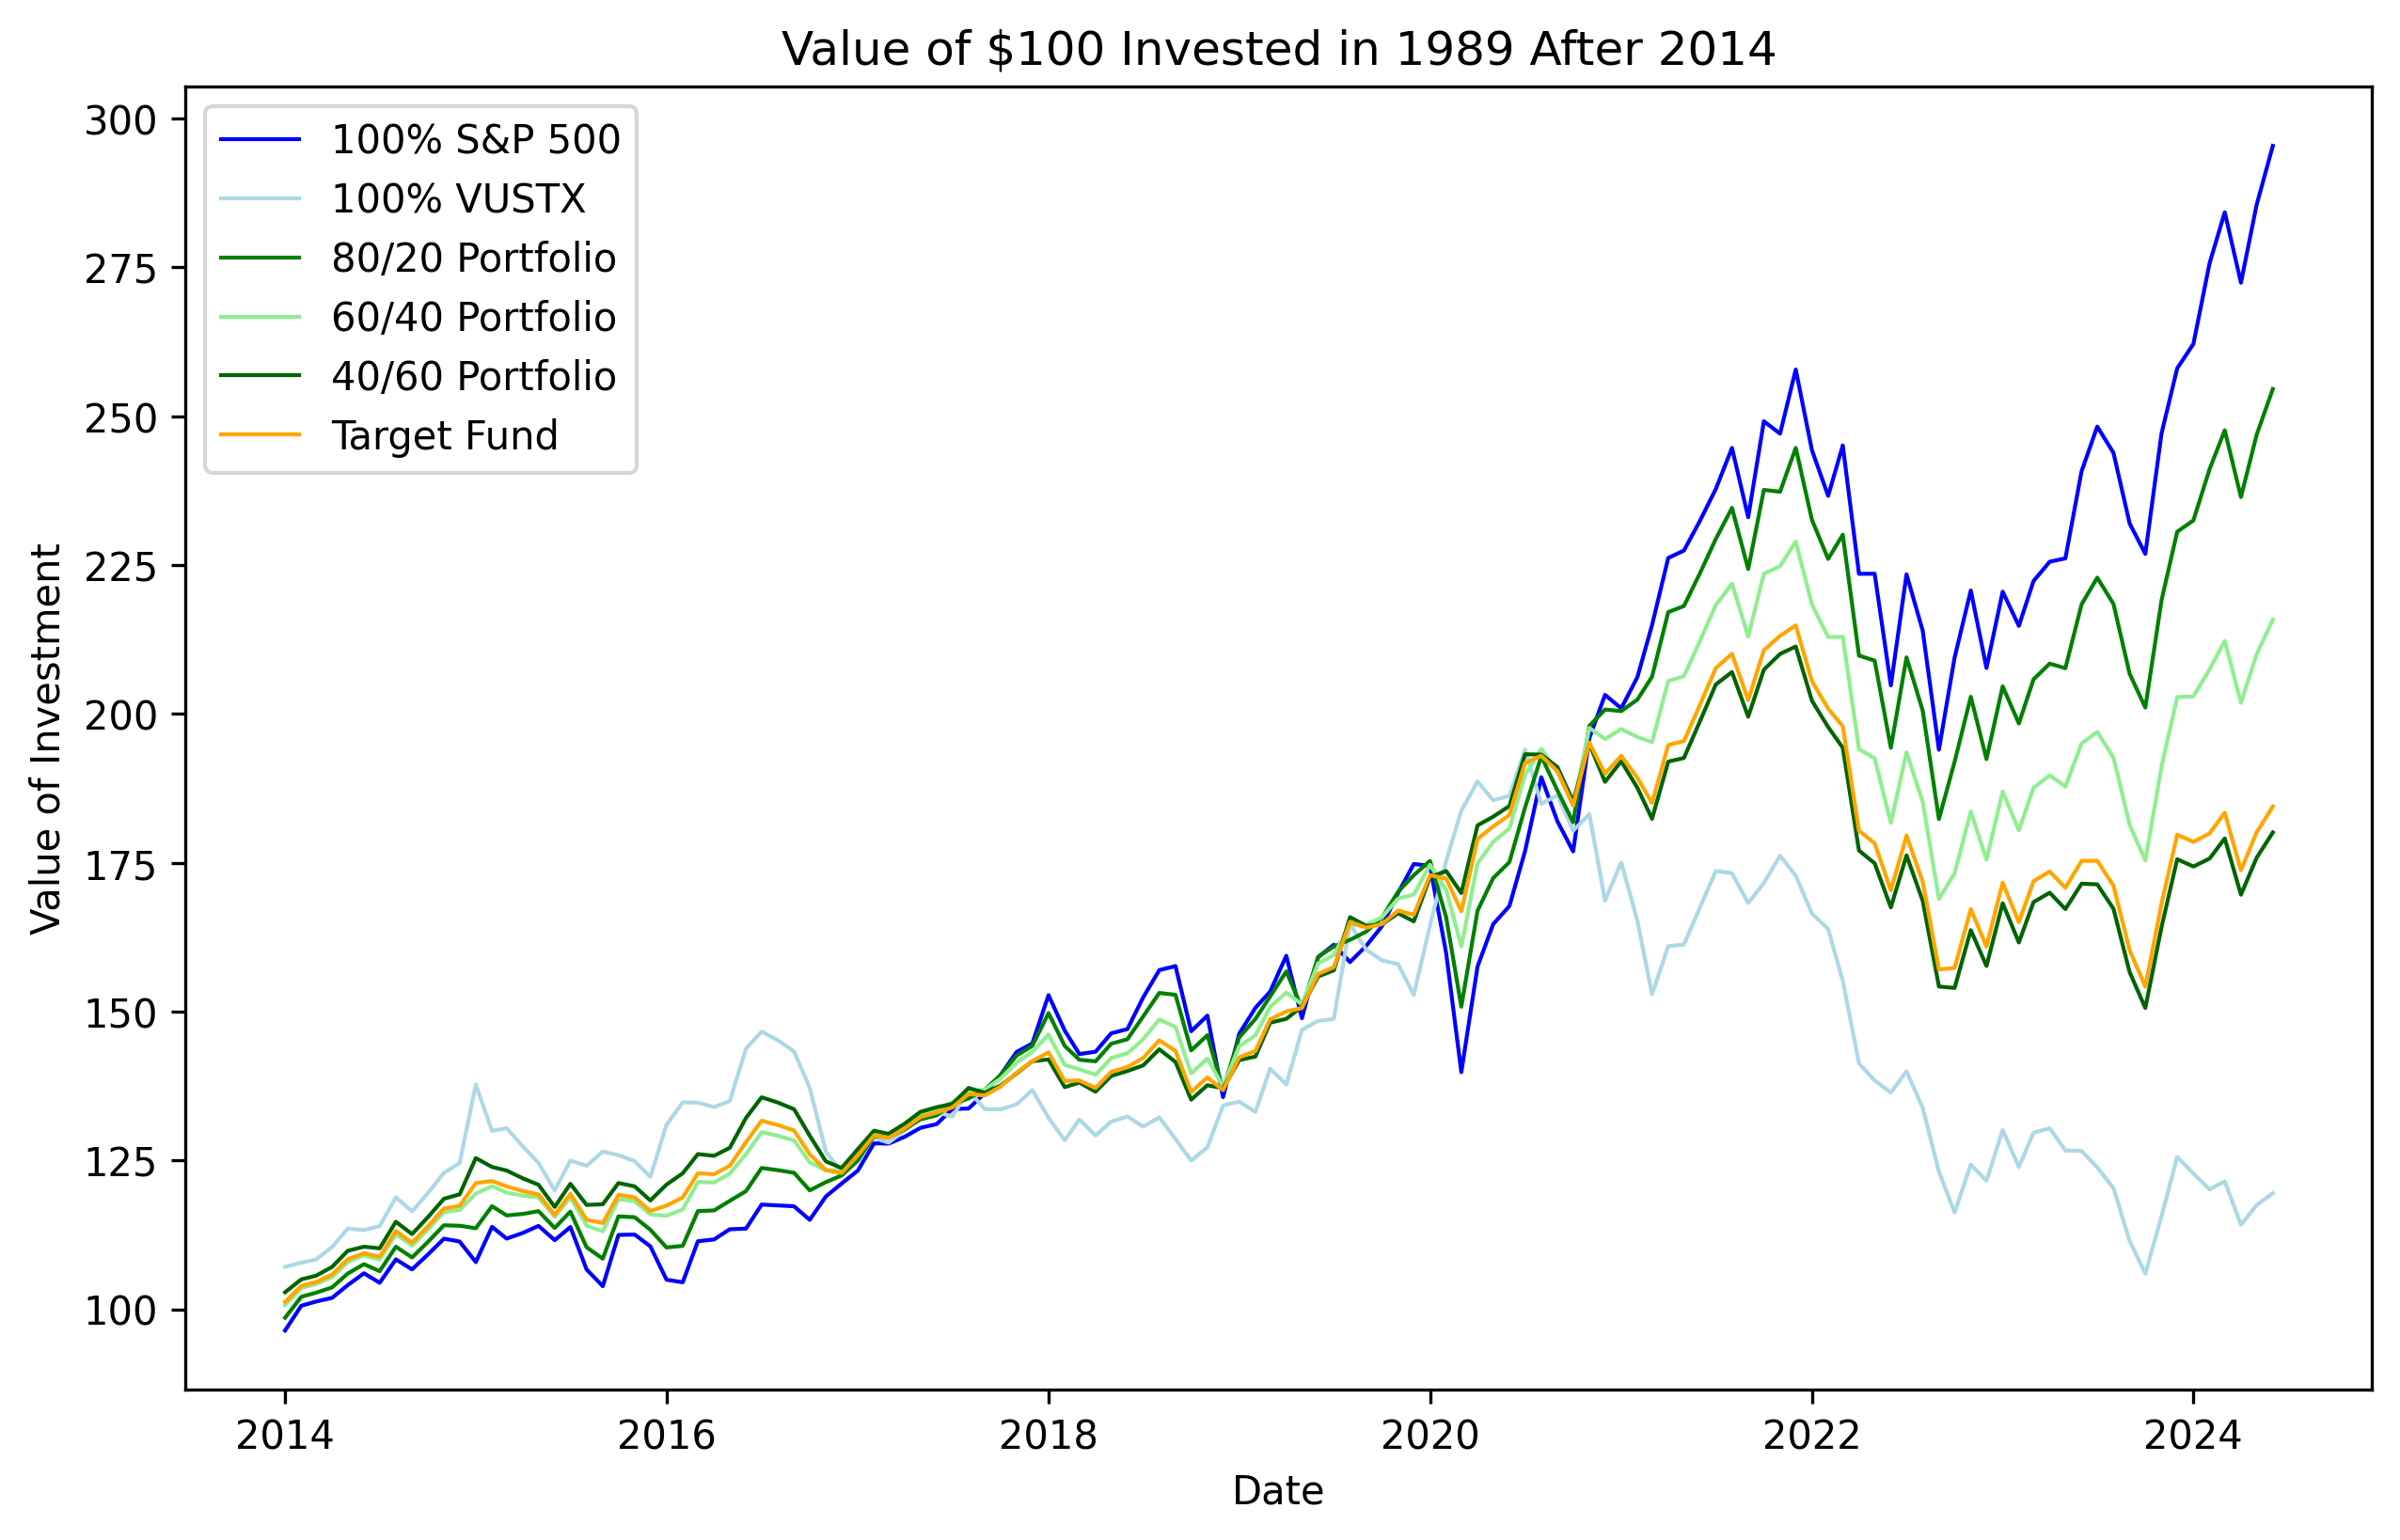

,SP500,VUSTX,80/20 Portfolio,60/40 Portfolio,40/60 Portfolio,Target Fund
Date,,,,,,
1989-10-01,-0.025175,0.038813,-0.012378,0.000420,0.013218,-0.018777
1989-11-01,0.016541,0.008675,0.014968,0.013395,0.011822,0.015745
1989-12-01,0.021417,-0.000689,0.016996,0.012574,0.008153,0.019153
1990-01-01,-0.068817,-0.036888,-0.062431,-0.056045,-0.049660,-0.065509
1990-02-01,0.008539,-0.002576,0.006316,0.004093,0.001870,0.007374
...,...,...,...,...,...,...
2024-02-01,0.051721,-0.021703,0.037036,0.022351,0.007667,0.008020
2024-03-01,0.031019,0.011335,0.027082,0.023145,0.019208,0.019279
2024-04-01,-0.041615,-0.060186,-0.045329,-0.049044,-0.052758,-0.052713


In [15]:
import sys
import subprocess
import importlib
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Ensure packages are properly installed and imported
def install_and_import(package, alias=None):
    try:
        module = importlib.import_module(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} installed successfully.")
        module = importlib.import_module(package)
        
    if alias:
        globals()[alias] = module
    else:
        globals()[package] = module

install_and_import('yfinance', alias='yf')
yf = globals()['yf']

# Function to calculate volatility
def vol_s(x):
    x = np.array(x)
    n = len(x)
    x_bar = np.mean(x)
    stdev = np.sqrt(np.sum((x - x_bar)**2) / (n - 1))
    return stdev

# Annualize return
def annualize_return(x):
    return (1 + x)**12 - 1

# Define start and end dates
startdate = "1989-09-01"
startyear = startdate.split("-")[0]
end_date_vfinx = "2024-08-01"
end_date_gspix = "2024-07-01"

# Convert dates to datetime objects
startdate_dt = datetime.datetime.strptime(startdate, "%Y-%m-%d")
end_date_vfinx_dt = datetime.datetime.strptime(end_date_vfinx, "%Y-%m-%d")
end_date_gspix_dt = datetime.datetime.strptime(end_date_gspix, "%Y-%m-%d")

# Download S&P 500 data
SP500 = yf.download("^GSPC", start=startdate_dt, end=end_date_vfinx_dt, interval="1mo")

# Download VUST
VUSTX = yf.download("VUSTX", start=startdate_dt, end=end_date_gspix_dt, interval="1mo")

# Remove NA values
print("NaN values in SP500:")
print(SP500['Adj Close'].isna().sum())
print("NaN values in VUSTX:")
print(VUSTX['Adj Close'].isna().sum())

prices_data = pd.concat([SP500['Adj Close'], VUSTX['Adj Close']], axis=1, join='inner')
prices_data.columns = ['SP500', 'VUSTX']

# Calculate percentage returns
print("NaN values in SP500 pct change:")
print(SP500['Adj Close'].pct_change().isna().sum())
print("NaN values in VUSTX pct change:")
print(VUSTX['Adj Close'].pct_change().isna().sum())

SP500_returns = SP500['Adj Close'].pct_change().dropna()
VUSTX_returns = VUSTX['Adj Close'].pct_change().dropna() # do not calculate 

# Align both SP500_returns and VUSTX_returns by date
aligned_returns = pd.concat([SP500_returns, VUSTX_returns], axis=1, join='inner')
aligned_returns.columns = ['SP500', 'VUSTX']

aligned_returns['80/20 Portfolio'] = 0.8* aligned_returns['SP500'] + 0.2* aligned_returns['VUSTX']
aligned_returns['60/40 Portfolio'] = 0.6* aligned_returns['SP500'] + 0.4* aligned_returns['VUSTX']
aligned_returns['40/60 Portfolio'] = 0.4* aligned_returns['SP500'] + 0.6* aligned_returns['VUSTX']

# Target date fund allocation: 90% S&P and 10% Bonds to 40% S&P and 60% Bonds over 35 years
weight_date_row = (0.9 - 0.4) / (len(aligned_returns) - 1)
aligned_returns['Target Fund'] = 0

for i in range(len(aligned_returns)):
    new_value = aligned_returns.iloc[i]['SP500'] * (0.9 - weight_date_row * i) + \
                aligned_returns.iloc[i]['VUSTX'] * (0.1 + weight_date_row * i)
    
    aligned_returns.at[aligned_returns.index[i], 'Target Fund'] = new_value
    #print(0.9 - weight_date_row * i) 


# Plot cumulative returns
plt.figure(figsize=(10, 6), dpi=300)
plt.plot((1 + aligned_returns['SP500']).cumprod() * 100, label="100% S&P 500", linewidth=1, color='blue')
plt.plot((1 + aligned_returns['VUSTX']).cumprod() * 100, label="100% VUSTX", linewidth=1, color='lightblue')
plt.plot((1 + aligned_returns['80/20 Portfolio']).cumprod() * 100, label="80/20 Portfolio", linewidth=1, color='green')
plt.plot((1 + aligned_returns['60/40 Portfolio']).cumprod() * 100, label="60/40 Portfolio", linewidth=1, color='lightgreen')
plt.plot((1 + aligned_returns['40/60 Portfolio']).cumprod() * 100, label="40/60 Portfolio", linewidth=1, color='darkgreen')
plt.plot((1 + aligned_returns['Target Fund']).cumprod() * 100, label="Target Fund", linewidth=1, color='orange')


plt.title(f'Value of $100 Invested in {startyear} (Various Portfolios) (cumulative)')
plt.xlabel("Date")
plt.ylabel("Value of Investment")
plt.legend(loc="upper left")
plt.savefig('./portfolio_cumulative_returns.jpg')

plt.show()


# Plots splitting date into 3 periods

def plot_period_with_monthly_index(aligned_returns_period, title):
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot((1 + aligned_returns_period['SP500']).cumprod() * 100, label="100% S&P 500", linewidth=1, color='blue')
    plt.plot((1 + aligned_returns_period['VUSTX']).cumprod() * 100, label="100% VUSTX", linewidth=1, color='lightblue')
    plt.plot((1 + aligned_returns_period['80/20 Portfolio']).cumprod() * 100, label="80/20 Portfolio", linewidth=1, color='green')
    plt.plot((1 + aligned_returns_period['60/40 Portfolio']).cumprod() * 100, label="60/40 Portfolio", linewidth=1, color='lightgreen')
    plt.plot((1 + aligned_returns_period['40/60 Portfolio']).cumprod() * 100, label="40/60 Portfolio", linewidth=1, color='darkgreen')
    plt.plot((1 + aligned_returns_period['Target Fund']).cumprod() * 100, label="Target Fund", linewidth=1, color='orange')

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value of Investment")
    plt.legend(loc="upper left")
    plt.show()


before_2007_monthly = aligned_returns[:'2007']
between_2007_2014_monthly = aligned_returns['2007':'2013']
after_2014_monthly = aligned_returns['2014':]

plot_period_with_monthly_index(before_2007_monthly, 'Value of $100 Invested in 1989 until 2007')
plot_period_with_monthly_index(between_2007_2014_monthly, 'Value of $100 Invested in 1989 between 2007 and 2014')
plot_period_with_monthly_index(after_2014_monthly, 'Value of $100 Invested in 1989 After 2014')


aligned_returns

The five portfolios exhibit similar long-term growth trends, with the S&P 500 showing the highest overall returns but also more volatility. The bond-heavy VUSTX portfolio provides stability, especially during downturns, but underperforms in growth periods. The mixed portfolios balance risk and return, offering moderate growth with reduced volatility compared to the S&P 500.

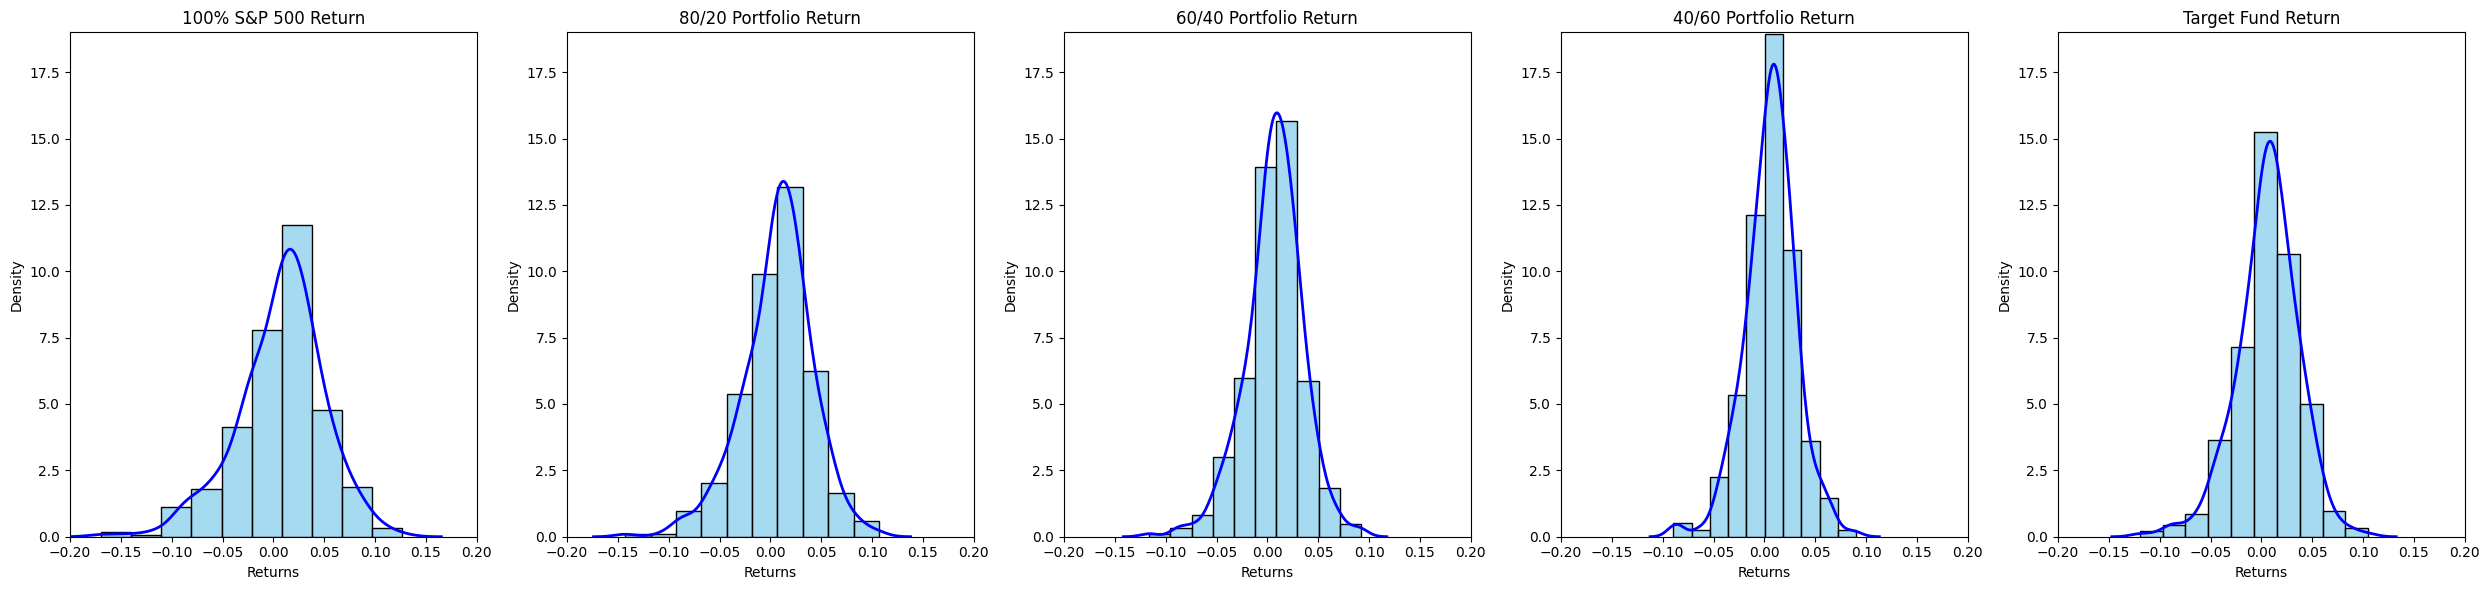

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 5 subplots
fig, ax = plt.subplots(1, 5, figsize=(25, 6))  # Adjusted figsize for better display of 5 plots

# Histogram and Density for 100% S&P 500
sns.histplot(aligned_returns['SP500'], bins=10, kde=False, ax=ax[0], color='skyblue', stat='density')
ax[0].set_xlim(-0.2, 0.2)
ax[0].set_ylim(0, 19)
ax[0].set_xlabel("Returns")
ax[0].set_title("100% S&P 500 Return")
sns.kdeplot(aligned_returns['SP500'], ax=ax[0], color='blue', linewidth=2)

# Histogram and Density for 80/20 Portfolio
sns.histplot(aligned_returns['80/20 Portfolio'], bins=10, kde=False, ax=ax[1], color='skyblue', stat='density')
ax[1].set_xlim(-0.2, 0.2)
ax[1].set_ylim(0, 19)
ax[1].set_xlabel("Returns")
ax[1].set_title("80/20 Portfolio Return")
sns.kdeplot(aligned_returns['80/20 Portfolio'], ax=ax[1], color='blue', linewidth=2)

# Histogram and Density for 60/40 Portfolio
sns.histplot(aligned_returns['60/40 Portfolio'], bins=10, kde=False, ax=ax[2], color='skyblue', stat='density')
ax[2].set_xlim(-0.2, 0.2)
ax[2].set_ylim(0, 19)
ax[2].set_xlabel("Returns")
ax[2].set_title("60/40 Portfolio Return")
sns.kdeplot(aligned_returns['60/40 Portfolio'], ax=ax[2], color='blue', linewidth=2)

# Histogram and Density for 40/60 Portfolio
sns.histplot(aligned_returns['40/60 Portfolio'], bins=10, kde=False, ax=ax[3], color='skyblue', stat='density')
ax[3].set_xlim(-0.2, 0.2)
ax[3].set_ylim(0, 19)
ax[3].set_xlabel("Returns")
ax[3].set_title("40/60 Portfolio Return")
sns.kdeplot(aligned_returns['40/60 Portfolio'], ax=ax[3], color='blue', linewidth=2)

# Histogram and Density for Target Fund
sns.histplot(aligned_returns['Target Fund'], bins=10, kde=False, ax=ax[4], color='skyblue', stat='density')
ax[4].set_xlim(-0.2, 0.2)
ax[4].set_ylim(0, 19)
ax[4].set_xlabel("Returns")
ax[4].set_title("Target Fund Return")
sns.kdeplot(aligned_returns['Target Fund'], ax=ax[4], color='blue', linewidth=2)

# Show the plot
plt.tight_layout()
plt.show()



Volatility: The 100% S&P 500 portfolio exhibits the most volatility, while portfolios with more bond exposure (40/60 and the Target Fund) show more stability and narrower return distributions.
Risk-Return Trade-Off: The riskier portfolios (S&P 500 and 80/20) offer the potential for higher returns but also expose investors to greater losses. On the other hand, the more conservative portfolios (60/40, 40/60, and Target Fund) offer more consistent but lower returns, better suited for risk-averse investors.
Balanced Approach: Portfolios with a mix of bonds and equities (like the 80/20 or 60/40 portfolios) attempt to balance risk and return, offering a compromise between high volatility and steady growth.
Overall, the histograms reflect how investors can choose between riskier, high-return portfolios or more stable, lower-return portfolios based on their investment goals and risk tolerance.

In [28]:
# Calculate Standard Deviation
std_dev = aligned_returns.std()

# Calculate Skewness
skewness = aligned_returns.skew()

# Calculate Kurtosis
kurtosis = aligned_returns.kurtosis()

print("Standard Deviation of Returns:")
print(std_dev)
print("\nSkewness of Returns:")
print(skewness)
print("\nKurtosis of Returns:")
print(kurtosis)



Standard Deviation of Returns:
SP500              0.042838
VUSTX              0.032228
80/20 Portfolio    0.034690
60/40 Portfolio    0.028423
40/60 Portfolio    0.025467
Target Fund        0.030622
dtype: float64

Skewness of Returns:
SP500             -0.542119
VUSTX              0.169287
80/20 Portfolio   -0.508461
60/40 Portfolio   -0.457430
40/60 Portfolio   -0.341995
Target Fund       -0.440266
dtype: float64

Kurtosis of Returns:
SP500              0.994289
VUSTX              1.039604
80/20 Portfolio    1.138488
60/40 Portfolio    1.408640
40/60 Portfolio    1.412502
Target Fund        1.269687
dtype: float64


The historical performance of the five portfolios can be assessed using three key measures: standard deviation, skewness, and kurtosis, which provide insights into their risk-return profiles.

Standard Deviation: Measuring Volatility
The S&P 500 has the highest standard deviation (0.0428), confirming it as the most volatile portfolio with the greatest exposure to fluctuations. In contrast, the 40/60 Portfolio has the lowest volatility (0.0255), emphasizing its stability due to a larger bond allocation. The 80/20 and 60/40 portfolios offer a balanced risk profile, with moderate volatility, making them appealing for investors seeking growth with controlled risk.

Skewness: Understanding Asymmetry in Returns
The S&P 500 (-0.5421) and other equity-heavy portfolios exhibit negative skewness, indicating a higher likelihood of large negative returns, aligning with their volatility. In contrast, VUSTX has positive skewness (0.1693), suggesting it’s more likely to experience positive returns, reinforcing its role as a stable bond portfolio. Mixed portfolios have less negative skewness, indicating reduced exposure to extreme losses compared to equities.

Kurtosis: Likelihood of Extreme Returns
The S&P 500 has lower kurtosis (0.9943), meaning it experiences fewer extreme returns compared to mixed portfolios. However, the 60/40 and 40/60 portfolios have higher kurtosis values (1.4086, 1.4125), suggesting that while they are less volatile overall, they still face occasional extreme returns. The Target Fund also shows moderate kurtosis (1.2697), reflecting its exposure to both stocks and bonds.

Conclusion
The S&P 500 is the most volatile portfolio, offering high growth potential but significant downside risk. VUSTX is the most stable, ideal for risk-averse investors. Mixed portfolios provide a balanced approach, combining moderate risk with growth potential, but with occasional exposure to extreme returns. Investors should carefully consider their risk tolerance when selecting among these portfolios, balancing stability with potential returns.

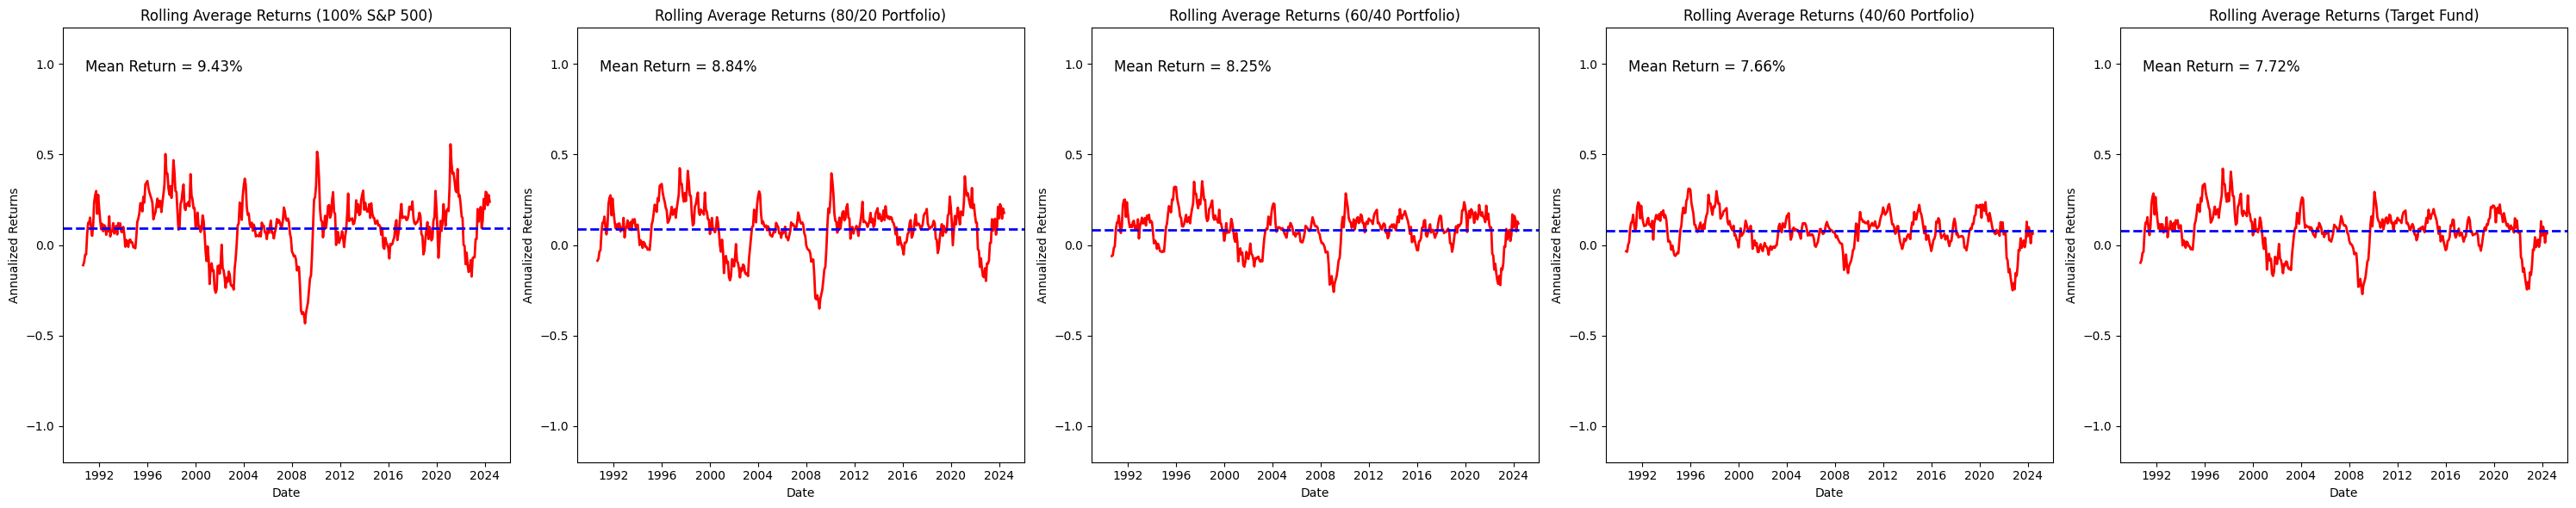

In [32]:
portfolios = {
    'SP500': "100% S&P 500",
    '80/20 Portfolio': "80/20 Portfolio",
    '60/40 Portfolio': "60/40 Portfolio",
    '40/60 Portfolio': "40/60 Portfolio",
    'Target Fund': "Target Fund"
}

# Create a figure with multiple subplots (one for each portfolio)
fig, ax = plt.subplots(1, 5, figsize=(30, 6))

rollmean = aligned_returns.rolling(window=12).mean()
annualized_rollmean = (1 + rollmean)**12 - 1

# Loop through the portfolios to plot each
for i, (key, title) in enumerate(portfolios.items()):
    # Plot rolling average returns
    ax[i].plot(annualized_rollmean[key], color='red', linewidth=2)
    ax[i].set_title(f"Rolling Average Returns ({title})")
    ax[i].set_ylim(-1.2, 1.2)
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Annualized Returns")

    # Calculate and plot the mean return as a horizontal line
    annualized_mean = annualize_return(aligned_returns[key].mean()) 
    ax[i].axhline(y=annualized_mean, color='blue', linestyle='--', linewidth=2)
    ax[i].text(0.05, 0.9, f"Mean Return = {round(annualized_mean*100, 2)}%", 
               transform=ax[i].transAxes, color='black', fontsize=12)

# Adjust layout and save the figure
plt.tight_layout()

# Display the plot
plt.show()


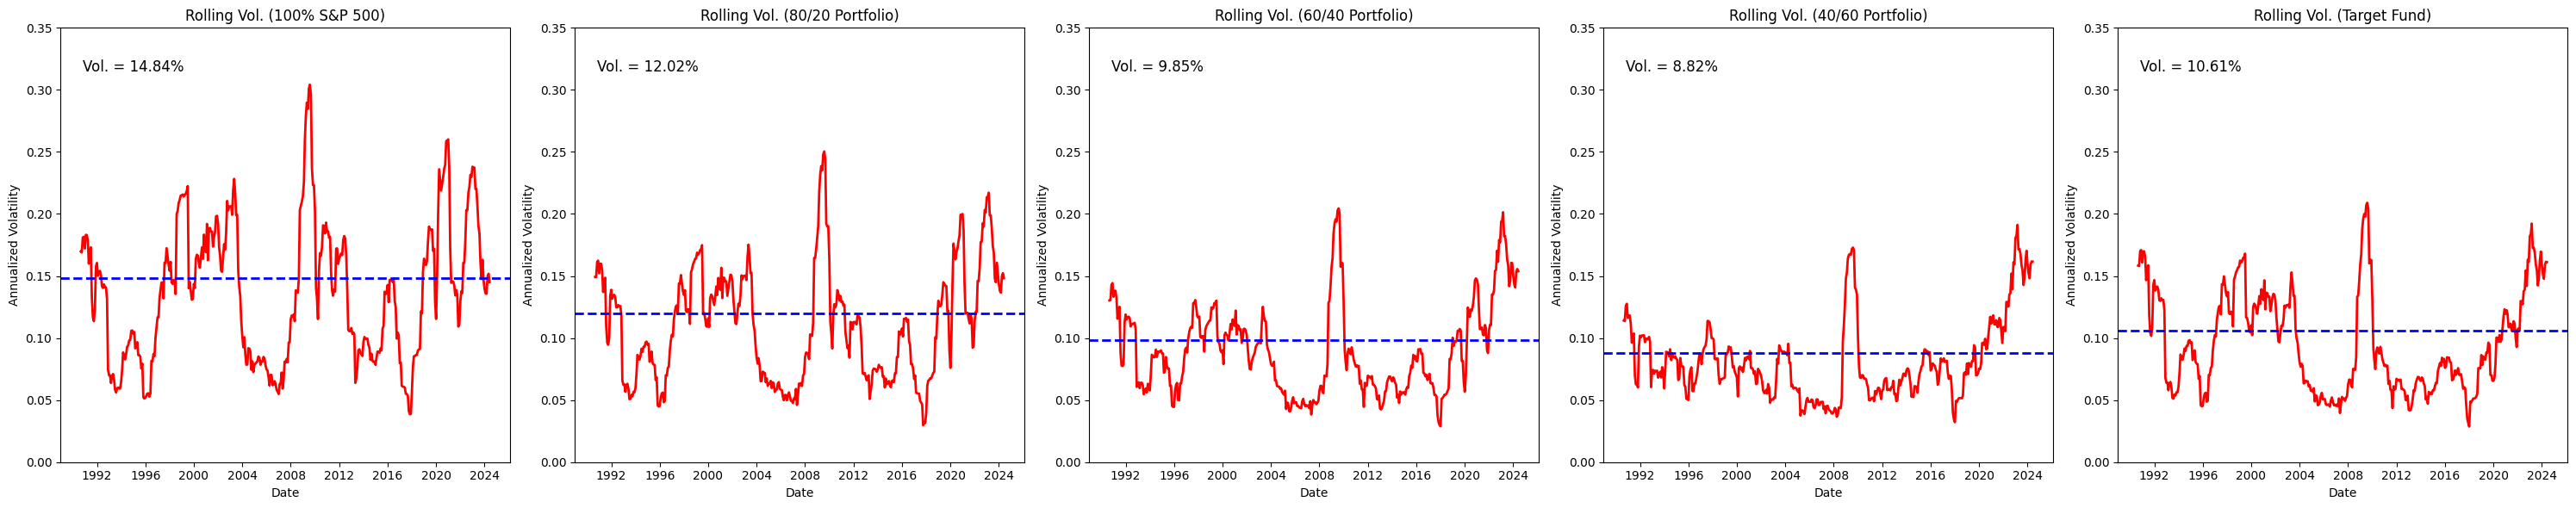

In [33]:
# Create a figure with multiple subplots (one for each portfolio)
fig, ax = plt.subplots(1, 5, figsize=(30, 6)) 

# Calculate the 12-month rolling annualized standard deviation
rollvol = aligned_returns.rolling(window=12).apply(vol_s, raw=True)

# Annualize the rolling volatility
annualized_rollvol = rollvol * np.sqrt(12)

portfolios = {
    'SP500': "100% S&P 500",
    '80/20 Portfolio': "80/20 Portfolio",
    '60/40 Portfolio': "60/40 Portfolio",
    '40/60 Portfolio': "40/60 Portfolio",
    'Target Fund': "Target Fund"
}
for i, (key, title) in enumerate(portfolios.items()):
    # Plot rolling annualized volatility
    ax[i].plot(annualized_rollvol[key], color='red', linewidth=2)
    ax[i].set_title(f"Rolling Vol. ({title})")
    ax[i].set_ylim(0, 0.35)
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Annualized Volatility")

    # Calculate and plot the mean volatility as a horizontal line
    annualized_vol = vol_s(aligned_returns[key]) * np.sqrt(12)
    ax[i].axhline(y=annualized_vol, color='blue', linestyle='--', linewidth=2)
    ax[i].text(0.05, 0.9, f"Vol. = {round(annualized_vol*100, 2)}%", transform=ax[i].transAxes, color='black', fontsize=12)


plt.tight_layout()
plt.show()


The rolling average return and volatility plots offer a clear view of the historical performance and risk profiles of the five portfolios.

Rolling Average Returns: Long-Term Growth
The S&P 500 boasts a mean return of 9.43%, showing strong long-term growth, but also significant fluctuations during downturns like 2000 and 2008. The 80/20 Portfolio offers a slightly lower return of 8.84% but with less volatility, striking a good balance between growth and risk. The 60/40 Portfolio, with a mean return of 8.25%, is more conservative, providing smoother performance with less fluctuation. The 40/60 Portfolio yields 7.66%, offering the most stability with smaller fluctuations, ideal for risk-averse investors. The Target Fund shows a return of 7.72%, providing balance by gradually shifting to safer assets over time.

Rolling Volatility: Risk Exposure
The S&P 500 has the highest volatility at 14.84%, confirming its high-risk, high-reward nature. The 80/20 Portfolio is less volatile at 12.02%, offering stability with growth potential. The 60/40 Portfolio reduces risk further, with volatility at 9.85%, while the 40/60 Portfolio exhibits the lowest volatility at 8.82%, prioritizing risk reduction. The Target Fund has a moderate volatility of 10.61%, reflecting its balanced approach as it nears the target date.

Conclusion: Balancing Risk and Return
The S&P 500 offers the highest returns but with substantial volatility. The 80/20 and 60/40 portfolios provide a balanced risk-return profile, while the 40/60 Portfolio and Target Fund focus on stability with lower returns. Investors must choose based on their risk tolerance and financial goals, as higher equity allocations lead to better growth but greater risk.

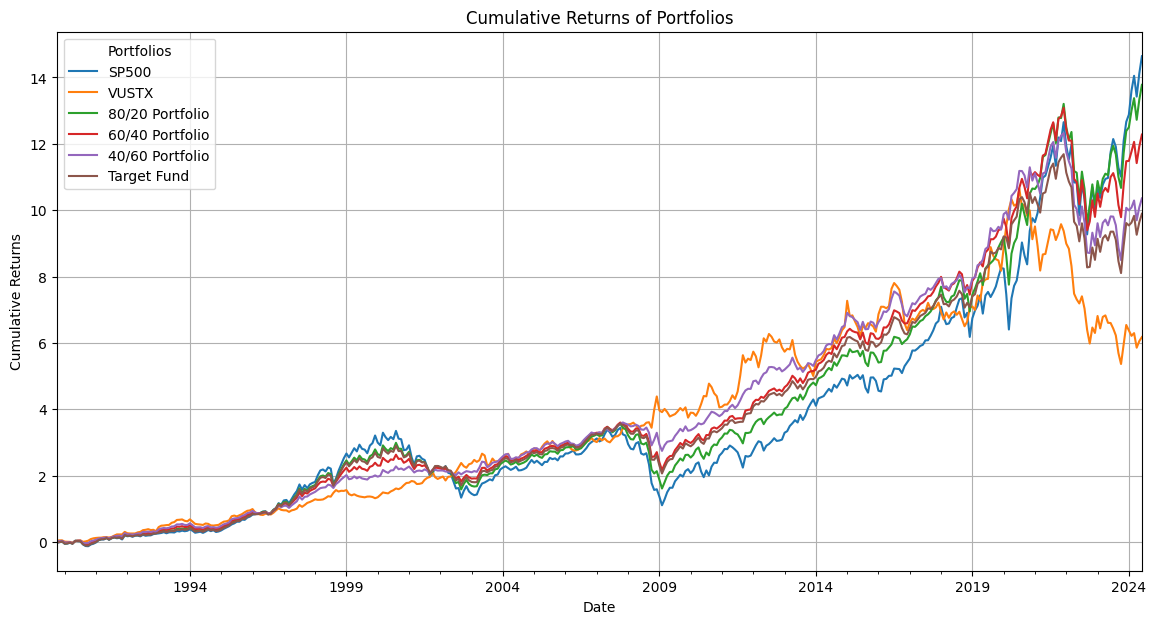

Annualized Returns:
SP500              1.900446
VUSTX              1.323223
80/20 Portfolio    1.785001
60/40 Portfolio    1.669557
40/60 Portfolio    1.554112
Target Fund        1.565574
dtype: float64

Annualized Volatility:
SP500              0.680039
VUSTX              0.511603
80/20 Portfolio    0.550684
60/40 Portfolio    0.451200
40/60 Portfolio    0.404275
Target Fund        0.486102
dtype: float64

Maximum Drawdown:
SP500             -0.525559
VUSTX             -0.453772
80/20 Portfolio   -0.427329
60/40 Portfolio   -0.312342
40/60 Portfolio   -0.287314
Target Fund       -0.329521
dtype: float64

Sharpe Ratio:
SP500              2.794612
VUSTX              2.586425
80/20 Portfolio    3.241424
60/40 Portfolio    3.700259
40/60 Portfolio    3.844196
Target Fund        3.220668
dtype: float64


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume 'aligned_returns' is your DataFrame containing the returns data for each portfolio
# Calculate cumulative returns
cumulative_returns = (1 + aligned_returns).cumprod() - 1

# Calculate annualized average returns
annualized_returns = aligned_returns.mean() * 252  # Assuming 252 trading days

# Calculate annualized volatility
annualized_volatility = aligned_returns.std() * np.sqrt(252)

# Calculate maximum drawdown
rolling_max = (1 + aligned_returns).cumprod().cummax()
daily_drawdown = (1 + aligned_returns).cumprod() / rolling_max - 1
max_drawdown = daily_drawdown.min()

# Calculate Sharpe Ratio (assume risk-free rate = 0)
sharpe_ratio = annualized_returns / annualized_volatility

cumulative_returns.plot(figsize=(14, 7))
plt.title('Cumulative Returns of Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(title="Portfolios")
plt.grid(True)
plt.show()

print("Annualized Returns:")
print(annualized_returns)
print("\nAnnualized Volatility:")
print(annualized_volatility)
print("\nMaximum Drawdown:")
print(max_drawdown)
print("\nSharpe Ratio:")
print(sharpe_ratio)


The metrics for annualized returns, annualized volatility, and maximum drawdown offer a detailed view of the risk-return profiles of the five portfolios, further building on the previous analyses of their performance.

Annualized Returns: Assessing Growth Potential
The S&P 500 achieves the highest annualized return at 1.90, confirming its role as the top-performing portfolio in terms of growth. This high return reflects the potential for strong equity-driven gains over time. The 80/20 Portfolio follows closely with a return of 1.78, offering a good mix of growth and stability by incorporating bonds into its allocation. The 60/40 Portfolio (1.67%) and 40/60 Portfolio (1.55%) show progressively lower returns as bond exposure increases, reducing growth potential but offering more consistency. The Target Fund stands at 1.57, striking a balance between moderate returns and reduced risk. VUSTX, with a return of 1.32%, reflects the lowest growth, focusing on minimizing risk through its bond-heavy structure.

Annualized Volatility: Measuring Risk
In terms of volatility, the S&P 500 shows the highest annualized volatility at 0.68, reinforcing its high-risk, high-reward nature. The 80/20 Portfolio reduces this risk slightly, with volatility at 0.55, offering more stability while maintaining growth potential. The 60/40 Portfolio, with volatility at 0.45, and the 40/60 Portfolio at 0.40, provide progressively lower volatility, making them more attractive to risk-averse investors. The Target Fund (0.49) and VUSTX (0.51) maintain lower volatility, prioritizing capital preservation and stability over aggressive growth.

Maximum Drawdown: Managing Losses
The S&P 500 experiences the largest maximum drawdown at -0.53, highlighting its vulnerability during major market downturns. The 80/20 Portfolio also sees significant drawdowns at -0.43, though bond exposure cushions losses somewhat. The 60/40 Portfolio (-0.31%) and 40/60 Portfolio (-0.29%) experience smaller drawdowns, reflecting their more conservative approach to risk. VUSTX, with a drawdown of -0.45%, still faces notable losses despite its bond-heavy allocation. The Target Fund has a moderate drawdown of -0.33%, consistent with its gradual shift toward conservative investments as it nears the target date.

Conclusion: Balancing Risk and Return
The S&P 500 provides the highest returns but also comes with the most volatility and steepest drawdowns, making it best suited for investors with a high-risk tolerance. The 80/20 Portfolio offers a more balanced approach, delivering strong returns with somewhat lower risk. The 60/40 and 40/60 Portfolios continue to reduce volatility and drawdowns, prioritizing stability over growth. VUSTX and the Target Fund focus primarily on minimizing risk and volatility, ideal for investors seeking capital preservation with lower returns.

Overall, these metrics support the view that portfolios with higher equity exposure deliver better growth but also face higher volatility and deeper losses during market downturns, while bond-heavy portfolios provide more stable, consistent performance with limited growth.


b) - c)
Portfolio Recommendation for a 30-Year-Old U.S. Investor Saving for Retirement
For a 30-year-old investor with a long-term horizon of 35 years until retirement, I would recommend the 80/20 Portfolio. This portfolio offers a good balance between growth potential and stability, with an annualized return of 1.78 and moderate volatility of 0.55. The higher equity exposure allows the investor to benefit from market growth over the long term, while the bond allocation provides a cushion during market downturns.

Growth Potential: With equities making up 80% of the portfolio, it allows the investor to capitalize on the stock market's growth, essential for accumulating wealth over a long period.
Risk Tolerance: At 30 years old, the investor can afford to take on more risk, as they have ample time to recover from short-term market volatility.
Volatility Management: The bond allocation helps to reduce the portfolio's overall volatility, ensuring the investor isn't fully exposed to market crashes, as seen in the lower maximum drawdown of -0.43% compared to the S&P 500's -0.53%.
Recommendation for a 60-Year-Old Investor
For a 60-year-old investor, the recommendation would shift toward the 40/60 Portfolio. With only 5 years left until retirement, the focus should be on capital preservation and reducing risk exposure.

Stability: The 40/60 Portfolio has an annualized volatility of 0.40, which is significantly lower than portfolios with higher equity exposure. This helps protect the portfolio from large losses as the investor nears retirement.
Lower Drawdowns: The maximum drawdown of -0.29% in this portfolio reflects its ability to protect against major market downturns, essential for an investor with a short time horizon.
Adequate Growth: While the annualized return of 1.55 is lower than equity-heavy portfolios, it is still sufficient for modest growth, allowing the investor to benefit from some market upside without taking on excessive risk.
Potential Caveats in the Analysis
Historical Performance: The analysis is based on historical returns, volatility, and drawdowns. However, past performance is not a guarantee of future results, and the financial markets may behave differently in the future due to changing economic conditions, interest rates, or geopolitical factors.
Inflation Risk: The portfolios analyzed do not explicitly factor in inflation adjustments. Over a long investment horizon, such as 35 years, inflation could erode purchasing power, and the expected returns might not be as impactful in real terms.
Interest Rate Sensitivity: Portfolios with a higher bond allocation, such as the 40/60 Portfolio and VUSTX, may face additional risk from rising interest rates, which can negatively affect bond prices and overall portfolio returns.
Personal Risk Tolerance: The analysis assumes a moderate to high risk tolerance based on age. However, individual preferences for risk and return vary, and the recommended portfolio should align with the investor’s comfort level, not just their age and time horizon.
Conclusion
For a 30-year-old saving for retirement, the 80/20 Portfolio is recommended, as it balances growth and stability, allowing the investor to capitalize on market gains while managing risk. For a 60-year-old nearing retirement, the 40/60 Portfolio is preferable due to its focus on stability and capital preservation. However, the analysis has limitations, especially regarding assumptions based on historical performance and interest rate sensitivity, which must be considered when making investment decisions.